## Imports

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from MDAnalysis.lib.distances import distance_array
from MDAnalysis import units
from MDAnalysis.analysis import rdf

from openmm.unit import Quantity, Unit
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

import quantities
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pymbar import timeseries
from MDAnalysis.analysis import density
from tqdm import tqdm
import os
import json


/tmp/ipykernel_177217/3626084654.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*            

## Set working directory

In [2]:
# ffs=input("Which force fields? (Options: JC, CHARMM27)")
# os.chdir("/home/bamo6610/Documents/GROMACS_files/MDAnalysis/SPW_ALL/%s"%ffs)

os.chdir("/home/bamo6610/Documents/openff-dev/HW_openMM/OpenMM_sims_HPs/")

## Loading data and creating atom group of ions

In [3]:
### 3.5 molal ##
u= mda.Universe('md.pdb', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname NA CL')

# u_r1 = mda.Universe('md.pdb', 'mdr1.xtc')
# u_r1.transfer_to_memory()
# ions_r1= u_r1.select_atoms('resname NA CL')

# u_r2 = mda.Universe('mdr2.pdb', 'mdr2.xtc')
# u_r2.transfer_to_memory()
# ions_r2= u_r2.select_atoms('resname NA CL')

# u_r3 = mda.Universe('mdr3.pdb', 'mdr3.xtc')
# u_r3.transfer_to_memory()
# ions_r3= u_r3.select_atoms('resname NA CL')

# us_ = [u,u_r1,u_r2,u_r3]
# ions_ = [ions,ions_r1,ions_r2,ions_r3]

## Density profiles using MDanalysis

In [44]:
def density_profile(universe, atom_group, bin_width=0.5, dim='z', method='res', frameby=1):
    '''Calculate the partial density across the box'''

    if isinstance(atom_group, str): # if provided selection language, make AtomGroup
        ag = universe.select_atoms(atom_group)
    else: # else assume input is AtomGroup
        ag = atom_group

    print(f'\nCalculating the partial density profile of {atom_group} in the {dim} dimension...')

    dims = {'x': 0, 'y': 1, 'z': 2}
    d = dims[dim]
    box = universe.dimensions[d]

    n_bins = int(box / bin_width)
    bins = np.linspace(0, box, num=n_bins)

    counts = np.zeros(n_bins)
        
    if len(universe.trajectory) == 0:
        for b in tqdm(range(n_bins-1)):
            lb = bins[b]
            ub = bins[b+1]
            bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)
            if method in ['atom', 'atoms', 'all']:
                counts[b] += len(bin_atoms)
            elif method in ['molecule', 'mol', 'residue', 'res']: 
                counts[b] += bin_atoms.n_residues
            elif method in ['mass', 'mass density']:
                box_dims = [box[i] for i in range(3) if i != d]
                dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                mass = bin_atoms.masses.sum() / 6.022 / 10**23
                counts[b] += mass / dV
    else:
        for ts in tqdm(universe.trajectory[::frameby]):
            for b in range(n_bins-1):
                lb = bins[b]
                ub = bins[b+1]
                bin_atoms = universe.select_atoms(f'prop {dim} > {lb} and prop {dim} < {ub} and group ag', ag=ag)

                if method in ['atom', 'atoms', 'all', 'number']:
                    counts[b] += len(bin_atoms)                 
                elif method in ['molecule', 'mol', 'residue', 'res']: 
                    counts[b] += bin_atoms.n_residues
                elif method in ['mass', 'mass density']:
                    box_dims = [box[i] for i in range(3) if i != d]
                    dV = box_dims[0] * box_dims[1] * (ub-lb) * (10**-8)**3
                    mass = bin_atoms.masses.sum() / 6.022 / 10**23
                    counts[b] += mass / dV

        counts = counts / len(universe.trajectory[::frameby])

    return bins, counts

In [45]:
nbins,ncounts=density_profile(u,ions)
# nbins1,ncounts1=density_profile(u1,ions1,2)
# nbins2,ncounts2=density_profile(u2,ions2,2)
# nbins3,ncounts3=density_profile(u3,ions3,2)


Calculating the partial density profile of <AtomGroup [<Atom 11101: Na00 of type Na of resname NA, resid 1 and segid I and altLoc >, <Atom 11102: Na01 of type Na of resname NA, resid 1 and segid J and altLoc >, <Atom 11103: Na02 of type Na of resname NA, resid 1 and segid K and altLoc >, ..., <Atom 11474: Cl18 of type Cl of resname CL, resid 1 and segid R and altLoc >, <Atom 11475: Cl18 of type Cl of resname CL, resid 1 and segid S and altLoc >, <Atom 11476: Cl18 of type Cl of resname CL, resid 1 and segid T and altLoc >]> in the z dimension...


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [02:47<00:00,  1.49it/s]


### Density plots

In [46]:
print(len(nbins))
print(len(ncounts))

288
288


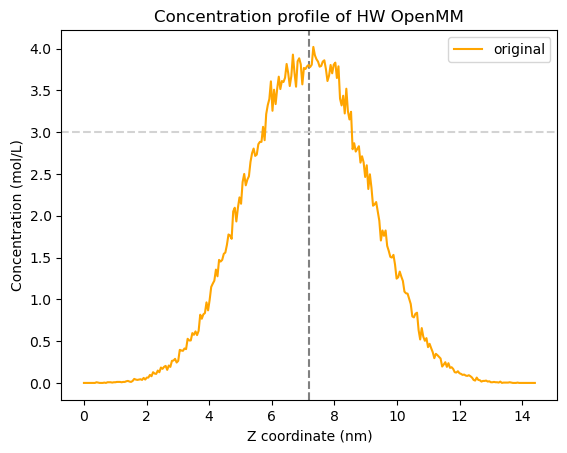

In [62]:
# nb=144.4/288
# volbin=48*48*nb*angstrom**3
# counts=(ncounts/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
# counts1=(ncounts1/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
# counts2=(ncounts2/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2
# counts3=(ncounts3/AVOGADRO_CONSTANT_NA)/volbin.in_units_of(litre)/2

bins=nbins/10
counts=ncounts
# bins1=nbins1/10
# bins2=nbins2/10
# bins3=nbins3/10

# print(counts)

# plt.axvline(x = 4.8, color = 'gray', label = 'walls', linestyle = 'dashed')
plt.axvline(x = 7.2, color = 'gray', linestyle = 'dashed')
plt.axhline(y = 3, color = 'lightgray', linestyle = 'dashed')
plt.plot(bins,counts, c='orange', label='original')
# plt.plot(bins1[1:],counts1, c='g', label='rep1')
# plt.plot(bins2[1:],counts2, c='c', label='rep2')
# plt.plot(bins3[1:],counts3, c='m', label='rep3')

plt.xlabel("Z coordinate (nm)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration profile of HW OpenMM")
plt.legend()
plt.show()

In [63]:
bins

array([ 0.        ,  0.050177  ,  0.100354  ,  0.15053101,  0.20070801,
        0.25088501,  0.30106201,  0.35123901,  0.40141602,  0.45159302,
        0.50177002,  0.55194702,  0.60212402,  0.65230103,  0.70247803,
        0.75265503,  0.80283203,  0.85300903,  0.90318604,  0.95336304,
        1.00354004,  1.05371704,  1.10389404,  1.15407104,  1.20424805,
        1.25442505,  1.30460205,  1.35477905,  1.40495605,  1.45513306,
        1.50531006,  1.55548706,  1.60566406,  1.65584106,  1.70601807,
        1.75619507,  1.80637207,  1.85654907,  1.90672607,  1.95690308,
        2.00708008,  2.05725708,  2.10743408,  2.15761108,  2.20778809,
        2.25796509,  2.30814209,  2.35831909,  2.40849609,  2.4586731 ,
        2.5088501 ,  2.5590271 ,  2.6092041 ,  2.6593811 ,  2.70955811,
        2.75973511,  2.80991211,  2.86008911,  2.91026611,  2.96044312,
        3.01062012,  3.06079712,  3.11097412,  3.16115112,  3.21132813,
        3.26150513,  3.31168213,  3.36185913,  3.41203613,  3.46

In [64]:
data_to_save = np.column_stack((bins, counts))
np.savetxt('density_test.txt', data_to_save, fmt='%.3f')